# LoRa Data Analysis -ADR vs. UCB


We first declare a fixed parameters.

Those parameters are not changed during the experiments.

Fixed communication parameters are listed below:
- Code Rate: 4/5
- Frequency: 866.1 MHz
- Bandwidth: 125 kHz

End nodes:
- were sending different types of uplink messages.
- were sending a single message each 2 minutes.
- used an upper confidence bound algorithm (UCB) for communication parameters selection.

Access points:
- only a single access point was used
- capture effect was also considered

Initial declaration

In [249]:
%matplotlib inline
import pandas as pd # import pandas
import numpy as np # import numpy
import matplotlib as mpl # import matplotlib
import matplotlib.pyplot as plt # import plotting module
import statistics
import math
import base64
from IPython.display import set_matplotlib_formats # module for svg export

output_format = 'svg'

set_matplotlib_formats(output_format) # set export to svg file
cut_ratio = 0.05 # Values below 5% of mean value are simply cut from charts to make it more readable

alg1 = 'adr'
alg2 = 'ucb'

uplink_messages = {alg1: 0, alg2: 1}
uplink_files = {alg1: 'adr_uplink_messages.csv', alg2: 'ucb_uplink_messages.csv'}

## Analysis of Uplink Messages

We read a csv file with uplink messages

In [250]:
uplink_messages[alg1] = pd.read_csv(uplink_files[alg1], delimiter=',')
uplink_messages[alg2] = pd.read_csv(uplink_files[alg2], delimiter=',')

Let us have a look at various columns that are present and can be evaluated.

In [251]:
uplink_messages[alg1].head()

,id,app_data,snr,rssi,duty_cycle_remaining,is_primary,receive_time,seq,frequency,spf,power,airtime,coderate,bandwidth,msg_group_number,message_type_id,ap_id,node_id
0,116216,Njk5OS4yLDYwMDEuNw==,2.9,-84.4,36000,t,2021-04-11 16:38:27.186,1,866100000,7,13,58,4/5,125000,315,1,111111,PHDA
1,116217,NjM0OC4wLDQ2NTIuMQ==,7.6,-72.8,36000,t,2021-04-11 16:38:31.707,1,866900000,12,15,1294,4/5,125000,221,2,111111,NBiG
2,116218,Mjg4MC40LDMxNjMuOQ==,-12.4,-88.8,36000,t,2021-04-11 16:38:37.242,1,866100000,7,13,58,4/5,125000,176,1,111111,8XwI
3,116219,NDgyOC44LDI1NzAuOQ==,-11.0,-86.1,36000,t,2021-04-11 16:38:42.26,1,866100000,7,13,58,4/5,125000,280,1,111111,vmmR
4,116220,MjI1NS43LDMwOTIuMQ==,-12.2,-92.4,36000,t,2021-04-11 16:38:47.26,1,866100000,7,13,58,4/5,125000,191,1,111111,DY9f


In [252]:
uplink_messages[alg2].head()

,id,app_data,snr,rssi,duty_cycle_remaining,is_primary,receive_time,seq,frequency,spf,power,airtime,coderate,bandwidth,msg_group_number,message_type_id,ap_id,node_id
0,102854,NzA3Ni44LDEzNTkuMQ==,2.5,-99.9,36000,t,2021-04-10 09:40:22.512,1,866100000,7,10,58,4/5,125000,124,1,111111,t3w0
1,102855,NTc4My4zLDQ5MDkuNw==,-17.4,-66.5,36000,t,2021-04-10 09:40:27.567,1,866100000,7,10,58,4/5,125000,111,2,111111,j6eI
2,102856,NzU4LjgsNjEzNS43,-12.6,-100.8,36000,t,2021-04-10 09:40:32.565,1,866100000,7,10,52,4/5,125000,155,2,111111,Qihc
3,102857,Njc2NC45LDMwNjAuMg==,-12.6,-90.5,36000,t,2021-04-10 09:40:38.065,1,866100000,7,10,58,4/5,125000,193,1,111111,iOK8
4,102858,OTExMy4xLDI4OTAuOA==,-17.6,-101.9,36000,t,2021-04-10 09:40:43.606,1,866100000,7,10,58,4/5,125000,252,1,111111,96VU


Remove all columns that have fixed values or there is no point in their analysis.

In [253]:
try:
    del uplink_messages[alg1]['id']
    del uplink_messages[alg1]['msg_group_number']
    del uplink_messages[alg1]['is_primary']
    del uplink_messages[alg1]['coderate']
    del uplink_messages[alg1]['bandwidth']
    del uplink_messages[alg1]['receive_time']
except KeyError:
    print('Columns have already been removed')

In [254]:
try:
    del uplink_messages[alg2]['id']
    del uplink_messages[alg2]['msg_group_number']
    del uplink_messages[alg2]['is_primary']
    del uplink_messages[alg2]['coderate']
    del uplink_messages[alg2]['bandwidth']
    del uplink_messages[alg2]['receive_time']
except KeyError:
    print('Columns have already been removed')

### Payload Length

In [255]:
uplink_messages[alg1]['payload_len'] = uplink_messages[alg1].app_data.apply(len)
uplink_messages[alg1]['payload_len'].describe()

count    3000.000000
mean       47.062667
std         5.197924
min        16.000000
25%        48.000000
50%        48.000000
75%        48.000000
max        52.000000
Name: payload_len, dtype: float64

In [256]:
payload_len = round(statistics.mean(uplink_messages[alg1].payload_len))
print(f'Mean value of payload length is {payload_len} B.')

Mean value of payload length is 47 B.


### Communication parameters selection

Let us create a new column 'arm'. This columns represents a combination of SF and TP and is referred in multi-armed bandit terminology as arm.

In [257]:
alg1_spf = uplink_messages[alg1].spf.astype(str).apply(lambda x: x.zfill(2))
alg2_spf = uplink_messages[alg2].spf.astype(str).apply(lambda x: x.zfill(2))
alg1_tp = uplink_messages[alg1].power.astype(str).apply(lambda x: x.zfill(2))
alg2_tp = uplink_messages[alg2].power.astype(str).apply(lambda x: x.zfill(2))
uplink_messages[alg1]['arm'] = 'S' + alg1_spf + 'P' + alg1_tp
uplink_messages[alg2]['arm'] = 'S' + alg2_spf + 'P' + alg2_tp

arms1 = uplink_messages[alg1].arm.value_counts()
threshold1 = round(statistics.mean(uplink_messages[alg1].arm.value_counts()) * cut_ratio, 2)
print(f'Values below {threshold1} will be cut from plot')
arms1 = arms1[arms1 > threshold1]

arms2 = uplink_messages[alg2].arm.value_counts()
threshold2 = round(statistics.mean(uplink_messages[alg2].arm.value_counts()) * cut_ratio, 2)
print(f'Values below {threshold2} will be cut from a plot')
arms2 = arms2[arms2 > threshold2]

diff = arms2 - arms1
diff.fillna(0)
arms_adr = [arms1, diff]
arms_adr = pd.concat(arms_adr, axis=1, sort=False).sum(axis=1)
arms_adr.sort_index(ascending=False, inplace=True)

diff = arms1 - arms2
diff.fillna(0)
arms_ucb = [arms2, diff]
arms_ucb = pd.concat(arms_ucb, axis=1, sort=False).sum(axis=1)
arms_ucb.sort_index(ascending=False, inplace=True)

Values below 25.0 will be cut from plot
Values below 16.17 will be cut from a plot


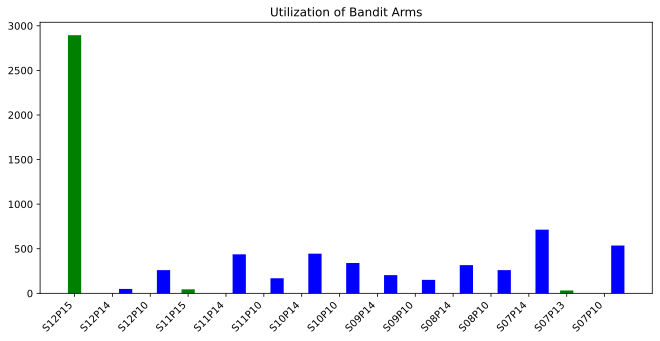

In [284]:
bar_width = 0.35
index = np.arange(len(arms_adr))
plt.figure(figsize=(11, 5))
plt.bar(index, arms_adr, width=bar_width, color='green', label = 'ADR')
plt.bar(index + bar_width, arms_ucb, width=bar_width, color='blue', label = 'UCB')

plt.xticks(index, arms_ucb.index, rotation = 45, horizontalalignment = 'right')

plt.title('Utilization of Bandit Arms')
plt.savefig(f'adr-ucb-bandit-arms.{output_format}', dpi=300)
plt.show()

### Spreading Factor

In [261]:
sf1 = uplink_messages[alg1].spf.value_counts()
sf2 = uplink_messages[alg2].spf.value_counts()

diff = abs(sf1 - sf2)
diff.fillna(0)
sf_adr = [sf1, diff]
sf_adr = pd.concat(sf_adr, axis=1, sort=False).sum(axis=1)
sf_adr.sort_index(ascending=False, inplace=True)

diff = abs(sf2 - sf1)
diff.fillna(0)
sf_ucb = [sf2, diff]
sf_ucb = pd.concat(sf_ucb, axis=1, sort=False).sum(axis=1)
sf_ucb.sort_index(ascending=False, inplace=True)

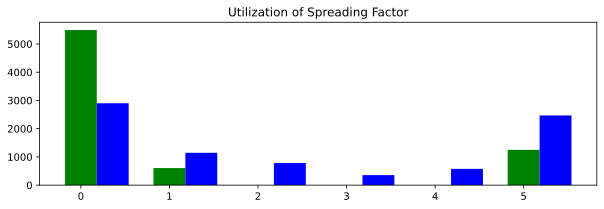

In [285]:
bar_width = 0.36
index = np.arange(len(sf_adr))
plt.figure(figsize=(10, 3))
plt.bar(index, sf_adr, width=bar_width, color='green', label = 'ADR')
plt.bar(index + bar_width, sf_ucb, width=bar_width, color='blue', label = 'UCB')

# plt.xticks(index, sf_ucb.index, horizontalalignment = 'right')

plt.title('Utilization of Spreading Factor')
plt.savefig(f'adr-ucb-sf.{output_format}', dpi=300)
plt.show()

All nodes used the same frequency to increase a probability of collisions.

We have only a single Access Point.

## Analysis of End Nodes

Analysis of certain aspects (active time, sleep time and collisions) of end devices.

In [290]:
adr_unique_ens = uplink_messages[alg1].node_id.nunique()
ucb_unique_ens = uplink_messages[alg2].node_id.nunique()

print(f'Number of end nodes participating in the {alg1} experiment is {adr_unique_ens}.')
print(f'Number of end nodes participating in the {alg2} experiment is {ucb_unique_ens}.')

Number of end nodes participating in the adr experiment is 90.
Number of end nodes participating in the ucb experiment is 88.


In [22]:
adr_end_nodes = pd.read_csv(f'{alg1}_end_nodes.csv', delimiter=',')
adr_end_nodes = pd.read_csv(f'{alg1}_end_nodes.csv', delimiter=',')

,dev_id,active_time,uptime,collisions,messages,algorithm
0,nn66,0.16,24.28,2,0,ucb
1,jLn5,1.16,24.29,1,0,ucb
2,Hh7f,0.00,24.28,1,0,ucb
3,VGHy,0.21,24.31,2,0,ucb
4,xhil,0.16,24.33,4,0,ucb


### Collision Histogram

Cutting values is disabled.

In [23]:
no_collisions = end_nodes.collisions.value_counts()
threshold = statistics.mean(end_nodes.collisions.value_counts())
print(f'Values below {threshold} will be cut in a plot')

Values below 6.6 will be cut in a plot


In [24]:
collisions = end_nodes.collisions[end_nodes.collisions > threshold]
collisions.describe()

count    29.000000
mean      9.517241
std       3.066183
min       7.000000
25%       7.000000
50%       9.000000
75%      11.000000
max      22.000000
Name: collisions, dtype: float64

In [25]:
max_collisions = max(collisions)
min_collisions = min(collisions)
range_collisions = max_collisions - min_collisions
increment = math.ceil(range_collisions / 4)

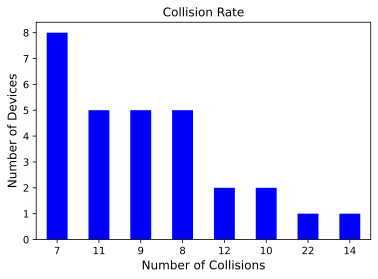

In [26]:
# out = pd.cut(collisions, bins=[min_collisions, min_collisions + increment, min_collisions + 2 * increment, min_collisions + 3 * increment, max(collisions)], include_lowest=True)
hist = collisions.value_counts().plot.bar(rot=0,color='b')
hist.set_xlabel('Number of Collisions',fontsize=12)
hist.set_ylabel('Number of Devices',fontsize=12)
plt.title('Collision Rate')
plt.savefig(f'{algorithm}-collisions.{output_format}', dpi=300)
plt.show()

In [27]:
mean_collisions = round(statistics.mean(collisions))
print(f'Mean collision number for each node was {mean_collisions}.')

Mean collision number for each node was 10.


### Ration between active time and total nodes uptime

In [28]:
energy = (end_nodes.active_time / end_nodes.uptime)
energy.describe()

count    99.000000
mean      0.024966
std       0.033963
min       0.000000
25%       0.002008
50%       0.010497
75%       0.041973
max       0.193291
dtype: float64

In [29]:
active_time = round(statistics.mean(energy) * 100, 2)
print(f'The nodes spent {active_time}% of their uptime in active mode.')

The nodes spent 2.5% of their uptime in active mode.


### Packet Delivery Ratio

Evaluation of packet delivery ratio for end nodes.

Add message count from uplink data and collisions.

In [30]:
data = uplink_data.node_id.value_counts()
nodes = pd.DataFrame({}, columns = ['dev_id', 'collisions', 'messages'])

collisions = []
messages = []
dev_id = []

for index,value in data.items():
    dev_id.append(index)
    collision_count = end_nodes.loc[end_nodes.dev_id == index].collisions.values[0]
    collisions.append(collision_count)
    messages.append(value + collision_count)

nodes['dev_id'] = dev_id
nodes['collisions'] = collisions
nodes['messages'] = messages

In [31]:
nodes['pdr'] = round((1 - (nodes.collisions / nodes.messages))*100, 2)
mean_pdr = round(statistics.mean(nodes.pdr), 2)
print(f'Mean value of Packet Delivery Ratio is {mean_pdr}%.')

Mean value of Packet Delivery Ratio is 80.85%.


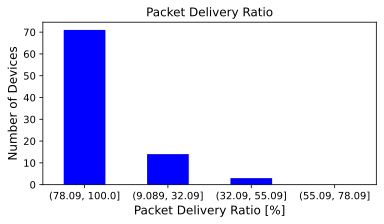

In [32]:
max_pdr = max(nodes.pdr)
min_pdr = min(nodes.pdr)
range_pdr = max_pdr - min_pdr
increment = math.ceil(range_pdr / 4)

out = pd.cut(nodes.pdr, bins=[min_pdr, min_pdr + increment, min_pdr + 2 * increment, min_pdr + 3 * increment, max_pdr], include_lowest=True)
hist = out.value_counts().plot.bar(rot=0,color='b',figsize=(6,3))
hist.set_xlabel('Packet Delivery Ratio [%]',fontsize=12)
hist.set_ylabel('Number of Devices',fontsize=12)

plt.title('Packet Delivery Ratio')
plt.savefig(f'{algorithm}-pdr.{output_format}', dpi=300)
plt.show()

## Path of Each End Node

Data about position are encoded as base64.

Decode base64, extract position and save the results to original data frame.

In [33]:
try:
    app_data = uplink_data.app_data.apply(base64.b64decode)
    app_data = app_data.astype(str)
    app_data = app_data.str.split(',')

    df = pd.DataFrame({}, columns = ['node_id', 'x', 'y'])

    x = []
    y = []

    for row in app_data:
        x.append(round(float(row[1].split('\'')[0]), 2))
        y.append(round(float(row[0].split('\'')[1]), 2))

    uplink_data['x'] = x
    uplink_data['y'] = y
    
    del uplink_data['app_data']
except KeyError:
    print('Column has already been removed')

In [34]:
uplink_data.head()

,snr,rssi,duty_cycle_remaining,seq,frequency,spf,power,airtime,message_type_id,ap_id,node_id,payload_len,arm,x,y
0,2.5,-99.9,36000,1,866100000,7,10,58,1,111111,t3w0,20,S7P10,1359.1,7076.8
1,-17.4,-66.5,36000,1,866100000,7,10,58,2,111111,j6eI,20,S7P10,4909.7,5783.3
2,-12.6,-100.8,36000,1,866100000,7,10,52,2,111111,Qihc,16,S7P10,6135.7,758.8
3,-12.6,-90.5,36000,1,866100000,7,10,58,1,111111,iOK8,20,S7P10,3060.2,6764.9
4,-17.6,-101.9,36000,1,866100000,7,10,58,1,111111,96VU,20,S7P10,2890.8,9113.1


Now, we draw a path for each end node based on the received coordinates.

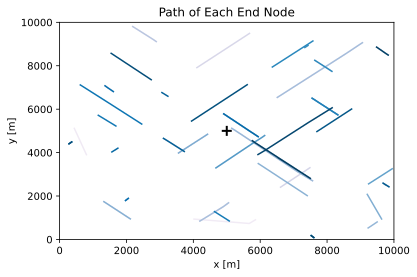

In [35]:
unique_ens = len(uplink_data.node_id.unique())
cmap = mpl.cm.get_cmap('PuBu')
xlim = 10000
ylim = 10000

for i in range(0, unique_ens):
    data = uplink_data[uplink_data.node_id == uplink_data.node_id[i]]
    plt.plot(data.x, data.y, color=cmap(i / unique_ens))
    
# Add Access Point
plt.plot(xlim / 2, ylim / 2, '+', mew=10, ms=2, color='black')

plt.title('Path of Each End Node')
plt.ylabel('y [m]')
plt.xlabel('x [m]')

plt.xlim([0,xlim])
plt.ylim([0,ylim])

# Figure is automatically saved
plt.savefig(f'{algorithm}-path.{output_format}', dpi=300)
plt.show()

The End. //////////\\\\'